In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/My Drive/Colab Notebooks/')

In [3]:
import DataPreprogress
import SSNMF_Reuters_t
from SSNMF_Reuters_t import SSNMF_Reuters_t
import SSNMF_torch
from SSNMF_torch import SSNMF_torch
import nltk
from nltk.corpus import reuters
nltk.download('reuters')
nltk.download('stopwords')
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [4]:
# Extract fileids from the reuters corpus
file_ids = reuters.fileids()
torch.set_printoptions(precision=10)
trn_data, tst_data, trn_labels, tst_labels, cuda0 = DataPreprogress.load_data(file_ids)
X_trn, X_tst = DataPreprogress.get_tfidf_matrices(trn_data, tst_data, max_feature = 600, cuda_device = cuda0)
#X_trn, trn_labels = DataPreprogress.shuffle(X_trn, trn_labels)
#X_tst, tst_labels = DataPreprogress.shuffle(X_tst, tst_labels)

GPU available


In [5]:
def get_lables_prediction(test_labels_approx, threshold):
  for i in range(test_labels_approx.size(1)):
    max = torch.max(test_labels_approx[:,i])
    min = torch.min(test_labels_approx[:,i])
    r = max - min
    test_labels_approx[:,i] = test_labels_approx[:,i] >= (min + threshold*r)
  return test_labels_approx

In [6]:
def threshold_analysis(exp,threshold_list):
  err = exp.eval()
  true_positive_rate_list = []
  false_positive_rate_list = []
  micro_F1_list = []

  for i in range(len(threshold_list)):
      test_labels_approx = exp.model.B @ exp.S_test
      pred_labels = get_lables_prediction(test_labels_approx, threshold_list[i])
      true_positive_rate = 0
      false_positive_rate = 0
      precision = 0
      sum_t_p = 0
      sum_f_p = 0
      sum_t_n = 0
      sum_f_n = 0
      for j in range(pred_labels.size(0)):
          confusion_vector = pred_labels[j]/tst_labels[j]

          t_p = torch.sum(confusion_vector == 1).item()
          f_p = torch.sum(confusion_vector == float('inf')).item()
          t_n = torch.sum(torch.isnan(confusion_vector)).item()
          f_n = torch.sum(confusion_vector == 0).item()

          sum_t_p = sum_t_p + t_p
          sum_f_p = sum_f_p + f_p
          sum_t_n = sum_t_n + t_n
          sum_f_n = sum_f_n + f_n

          true_positive_rate = true_positive_rate + t_p/(t_p + f_n)
          false_positive_rate = false_positive_rate + f_p/(f_p + t_n)

      true_positive_rate_list.append(true_positive_rate/90)
      false_positive_rate_list.append(false_positive_rate/90)

      micro_precision = sum_t_p/(sum_t_p + sum_f_p)
      micro_recall = sum_t_p/(sum_t_p + sum_f_n)
      
      micro_F1 = 2*(micro_precision * micro_recall)/(micro_precision + micro_recall)
      micro_F1_list.append(micro_F1)

  return true_positive_rate_list, false_positive_rate_list, micro_F1_list


In [7]:
def show_analysis_results(threshold_list, true_positive_rate_list, false_positive_rate_list, micro_F1_list):
  df = pd.DataFrame({
      "threshold(%)":threshold_list,
      "true_positive_rate":true_positive_rate_list,
      "false_positive_rate":false_positive_rate_list,
      "micro_F1_score":micro_F1_list
  })
  return df

In [8]:
def plot_roc(true_positive_rate_list, false_positive_rate_list):
  plt.figure()
  lw = 2
  plt.plot(false_positive_rate_list, true_positive_rate_list, marker='o', color='darkorange',
          lw=lw, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('thresholds&ROC')
  plt.legend(loc="lower right")
  plt.show()

  auc = metrics.auc(np.array(false_positive_rate_list), np.array(true_positive_rate_list))
  return auc

In [9]:
def plot_micro_F1(threshold_list,micro_F1_list):
  plt.figure()
  lw = 2
  plt.plot(threshold_list, micro_F1_list, marker='o', color='darkorange',
          lw=lw, label='micro_F1 curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1])
  plt.ylim([0.0, 1.05])
  plt.xlabel('thresholds')
  plt.ylabel('micro F1 scores')
  plt.title('micro F1')
  plt.legend(loc="lower right")
  plt.show()

In [44]:

exp_4 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=20, modelNum=4)
exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=20, modelNum=5)
exp_6 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=20, modelNum=6)

In [10]:
thresholds_list = [i/10000 for i in range(1,10)] + \
                  [i/100000 for i in range(100,200, 25)] + \
                  [i/1000 for i in range(2,10)] + \
                  [i/10000 for i in range(100,200, 25)] + \
                  [i/100 for i in range(2,10)] + \
                  [i/10 for i in range(1,10)]

In [11]:
exp_3 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=500, modelNum=3)
t_p_r_3, f_p_r_3, micro_F1_3 = threshold_analysis(exp_3, thresholds_list)

In [12]:
show_analysis_results(thresholds_list, t_p_r_3, f_p_r_3, micro_F1_3)

,threshold(%),true_positive_rate,false_positive_rate,micro_F1_score
0,0.00010,0.907695,0.806944,0.033305
1,0.00020,0.876064,0.756329,0.035392
2,0.00030,0.867787,0.722176,0.036968
3,0.00040,0.861396,0.695702,0.038260
4,0.00050,0.845156,0.673801,0.039389
5,0.00060,0.841536,0.654987,0.040426
6,0.00070,0.834657,0.638729,0.041384
7,0.00080,0.831371,0.624271,0.042260
8,0.00090,0.819651,0.611398,0.043079
9,0.00100,0.795172,0.599597,0.043797


In [13]:
t_p_r_3 = [1] + t_p_r_3 + [0]
f_p_r_3 = [1] + f_p_r_3 + [0]

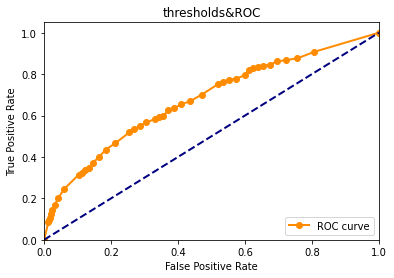

0.6764298351522445

In [14]:
plot_roc(t_p_r_3, f_p_r_3)

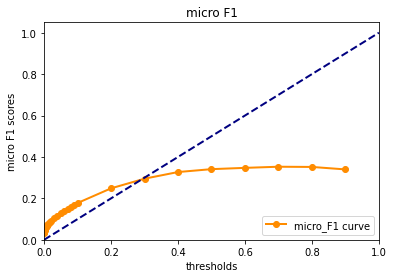

In [15]:
plot_micro_F1(thresholds_list,micro_F1_3)